In [1]:
import pandas as pd
import numpy as np
import farmhash
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.encoding import (
    OneHotEncoder,
    CountFrequencyEncoder
)

from feature_engine.transformation import (
    LogTransformer,
    LogCpTransformer
)

from feature_engine.selection import (
    DropFeatures,
    DropConstantFeatures,
    DropDuplicateFeatures,
    DropCorrelatedFeatures,
    RecursiveFeatureAddition,
    RecursiveFeatureElimination,
    SelectBySingleFeaturePerformance)

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate,RandomizedSearchCV,GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import fbeta_score,f1_score, confusion_matrix, precision_score,recall_score, precision_recall_fscore_support
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from skopt import BayesSearchCV
import joblib
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [2]:
#new features:

# Categorical new features 
#transactions hour: based on transaction timestamp
#transaction month: based on transaction timestamp
#transaction weekday: based on transaction timestamp
#transaction day# based on transaction timestamp
#year date of birth# based on date of birth
# len_cc: based on cc_num
# first_num_cc: based on cc_num
#purchase_type: based on category
#week_catgory: based on transaction weekday
#len_cc_cutoff: baed on len_cc
#is_midnight: based on transaction hour

# numerical new features
#log amount: based on amt
#avg_day_txn_volume: aggregation
#avg_day_txn_amount: aggregation based on transaction date and amt
#avg_amount_per_txn: aggregation
#txn_amount_std: aggregation
#amount_per_txn_std: aggregation

# transformationm
# hash encoded transformation: city, Zip code, job, merchant
# one hot encoding : transaction weekdays, transaction month, state,purchase_type,week_category
# fraud_weight_encoding: transaction weekdays, transaction month,transaction hours,transaction, state,purchase_type,week_category
# log transformation: amt,date of birth year
# Normalization: log amt, len_cc, log date of birth year

In [3]:
train = pd.read_csv("fraudTrain.csv")
train_target = train.is_fraud
train.drop(columns = ["Unnamed: 0","is_fraud"], inplace = True)



test = pd.read_csv("fraudTest.csv")
test_target = test.is_fraud
test.drop(columns = ["Unnamed: 0","is_fraud"], inplace = True)


In [4]:
### Date decomposition
def date_components(X,dates):
    
    
    
    X[dates] = pd.to_datetime(X[dates])
    X[dates+"_year"] = pd.DatetimeIndex(X[dates]).year
    X[dates+"_month"] = pd.DatetimeIndex(X[dates]).month
    X[dates+"_week"] = pd.DatetimeIndex(X[dates]).week
    X[dates+"_weekday"] = pd.DatetimeIndex(X[dates]).day_of_week
    X[dates+"_hour"] = pd.DatetimeIndex(X[dates]).hour
    X[dates+"_caldate"] = pd.DatetimeIndex(X[dates]).date
    X[dates+"_day"] = pd.DatetimeIndex(X[dates]).day

    return X




### Avg Daily txn Volume transformer
class Aggregator(BaseEstimator,TransformerMixin):
    
    def __init__(self,partition_col,agg_col = None,date_col = ["trans_date_trans_time_caldate"],agg_type = "mean",agg_value = "count"):
        
        self.partition_col = partition_col
        self.agg_type = agg_type
        self.date_col =  date_col
        self.agg_value = agg_value
        self.agg_col = agg_col
        
        
    def fit(self,X, y = None):
        
        X = X.copy()
        
        container = []
        for i in self.partition_col:
            for d in self.date_col:
            
                if self.agg_col  ==  None:

                    daily_sum = X.groupby([i,d] ).agg(value = (i, self.agg_value )).reset_index()

                else:

                    daily_sum = X.groupby([i,d] ).agg(value = (self.agg_col,self.agg_value )).reset_index()

                avg_daily_vol = daily_sum.groupby([i]).agg(avg_value=("value",self.agg_type)).to_dict()["avg_value"]
                container.append((avg_daily_vol,i,d))

            self.container = container
        
        return self
    
    def transform(self, X):
        
        X = X.copy()
        
        
                             
        for a,b,c in self.container:
            
            date_val = re.findall("(caldate|month|year|hour|weekday|week|day)",c)[0]
        
            X[b+"_"+self.agg_type+"_"+date_val+"_"+self.agg_value+"_"+str(self.agg_col)] = X[b].map(a)
            X[b+"_"+self.agg_type+"_"+date_val+"_"+self.agg_value+"_"+str(self.agg_col)].fillna(1,inplace = True)
        
        return X
        
        
    

### Avg Daily amount per txn


class AggAmtperTxn(BaseEstimator,TransformerMixin):
    
    def __init__(self,partition_col,agg_col = "amt",date_col = ["trans_date_trans_time_caldate"],agg_type = "mean"):
        
        self.partition_col = partition_col
        self.agg_type = agg_type
        self.date_col =  date_col
        self.agg_col = agg_col
        
        
    def fit(self,X, y = None):
        
        X = X.copy()
        
        container = []
        for i in self.partition_col:
            for d in self.date_col:
        
                daily_sum = X.groupby([i,d] ).agg(value = (self.agg_col, 'sum' ),count = (i,'count')).reset_index()

                daily_sum["amt_per_txn"] = daily_sum.apply(lambda x: x["value"]/x["count"], axis = 1)

                avg_daily_sum_vol = daily_sum.groupby([i]).agg(avg_value=("amt_per_txn",self.agg_type)).to_dict()["avg_value"]
                container.append((avg_daily_sum_vol,i,d) )

        self.container = container
        
        return self
    
    def transform(self, X):
        
        X = X.copy()
        
        
                             
        for a,b,c in self.container:
            
            date_val = re.findall("(caldate|month|year|hour|weekday|week|day)",c)[0]
        
            X[b+"_"+self.agg_type+"_"+date_val+"_"+self.agg_col+"_per_txn"]  = X[b].map(a)
            X[b+"_"+self.agg_type+"_"+date_val+"_"+self.agg_col+"_per_txn"] .fillna(1,inplace = True)
        
        return X

    
### hash data 
class FarmHash(BaseEstimator,TransformerMixin):
    
    def __init__(self,col):
        
        self.col = col
        
    
    def fit(self,X,y = None):
        
        return self
            
            
            
    
    def transform(self,X):
        
        
        X = X.copy()
        
        for c in self.col:
            
            X[c] = X[c].map(lambda x: farmhash.fingerprint32(str(x) ))
            
        return X
        
        
#### date decomposition

class DateDecomp(BaseEstimator,TransformerMixin):
    
    def __init__(self,col):
        
        self.col = col
        
    def fit(self,X,y = None):
        
        return self
    
    def transform(self,X):
        
        X = X.copy()
        
        for c in self.col:
            result = date_components(X,c)
        
        return result
    
    

#### fraud frequency 
    
class FraudFreq(BaseEstimator,TransformerMixin):
    
    def __init__(self, col):
        
        
        self.col = col
        
        
    def fit(self,X,y= None):
        
        
        container = []
        X=  X.copy()
        X["is_fraud"] = y
        
        
        for c in self.col:
            
            freq = X.groupby(c)["is_fraud"].mean().to_dict()
            container.append(freq)
        
        self.freq = container
        
        return self
    
    def transform(self,X):
        
        X = X.copy()
        
        for f,c in zip(self.freq,self.col) :
            
            X[c+"_fraud_freq"] = X[c].map(f)
            
        return X
    
    
class ValueLength(BaseEstimator,TransformerMixin):
    
    def __init__(self,col):
        
        self.col = col
        
    def fit(self,X,y = None):
        
        return self
    
    def transform(self,X):
        
        X = X.copy()
        
        for c in self.col:
            
            X[c+"_length"] = X[c].map(lambda x: len(str(x)))
                            
        return X
            
        
        
class WeekCategory(BaseEstimator,TransformerMixin):
    
    def __init__(self,col):
        
        self.col = col
        
    def fit(self,X,y = None):
        
        return self 
    
    def transform(self,X):
        
        X = X.copy()
        
        
        for c in self.col:
            
            X[c+"_category"] =  X[c].map(lambda x: "Weekend" if x in [0,6]  else "start_end_week" if x in [1,5] else "midweek")
        
        return X
        
        
class PurchaseType(BaseEstimator,TransformerMixin):
    
    def __init__(self,col):
        
        self.col = col
    
    def fit(self,X,y = None):
        
        return self
    
    def transform(self,X):
        
        X = X.copy()
        
        for c in self.col:
            
            X[c+"_purchase_type"] = X[c].map(lambda x: "net" if re.search("net",str(x) ) else "pos" if re.search("pos",str(x) ) else "other")
            
        return X

class ReplaceNaN(BaseEstimator,TransformerMixin):
    
    def __init__(self):
        
        pass
        
    def fit(self,X,y=None):
        
        return self
    
    def transform(self,X):
        
        X = X.copy()
        
        for c in X.columns.tolist():
            
            X[c] = X[c].replace(to_replace = [np.inf,-np.inf,np.nan],value = 0)
            
        return X
    
    
class SelectFeatures(BaseEstimator,TransformerMixin):
    
    def __init__(self,cols):
        
        self.cols = cols
        
    def fit(self,X,y = None):
        
        return self
    
    def transform(self,X):
        
        X = X.copy()
        
        return X[self.cols]
    

#class DownSampling(BaseEstimator,TransformerMixin):
    
#    def __init__(self):
        
        
    

In [5]:
cols_to_drop = ['trans_date_trans_time',
                'first',
                'last',
                'dob',
                'trans_num',
                'unix_time',
                'trans_date_trans_time_caldate',
                'dob_caldate'
                
               ]


pp_list = [
    
    ("cc_length",ValueLength(col=["cc_num"]))
    
    ,("txn_date_decom",DateDecomp(col = ["trans_date_trans_time"]))
    
    ,("dob_decomp",DateDecomp(col = ["dob"]))
    
    ,("WeekdayCat",WeekCategory(["trans_date_trans_time_weekday"]))
    
    ,("purchase_cat",PurchaseType(["category"]))
    
    #,("daily_amount",Aggregator(partition_col=["cc_num","state","zip","merchant","city","category","gender"],agg_col="amt",agg_value="sum"))
    
    ,("avg_txn_amount",Aggregator(partition_col=["cc_num","state","zip","merchant","city","category","gender","job"],date_col=['trans_date_trans_time_caldate',
                                                                                                                       'trans_date_trans_time_year',
                                                                                                                       'trans_date_trans_time_month',
                                                                                                                       'trans_date_trans_time_week',
                                                                                                                       'trans_date_trans_time_weekday'],agg_col="amt",agg_value="sum"))
    
    ,("std_amt_per_txn",AggAmtperTxn(partition_col=["cc_num","state","zip","merchant","city","category","gender","job"],date_col=['trans_date_trans_time_caldate',
                                                                                                                       'trans_date_trans_time_year',
                                                                                                                       'trans_date_trans_time_month',
                                                                                                                       'trans_date_trans_time_week',
                                                                                                                       'trans_date_trans_time_weekday'],agg_type='std'))
    
    
    ,("daily_volume",Aggregator(partition_col=["cc_num","state","zip","merchant","city","category","gender"],agg_value="count"))
    
    ,("amt_per_txn",AggAmtperTxn(partition_col=["cc_num","state","zip","merchant","city","category","gender"]))
    
    ,("avg_merchants_year",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_year"],agg_value="nunique" ) )
    ,("avg_merchants_month",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_month"],agg_value="nunique" ) )
    ,("avg_merchants_week",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_week"],agg_value="nunique" ) )
    ,("avg_merchants_weekday",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_weekday"],agg_value="nunique" ) )
    
    
    ,("fraud_freq",FraudFreq(col = ["trans_date_trans_time_month","trans_date_trans_time_weekday","trans_date_trans_time_hour","state","trans_date_trans_time_weekday_category","category_purchase_type","gender"]))
    
    
    ,("hash_value",FarmHash(col = ["cc_num","city","merchant","category","zip","street",'job']))
    
    ,("hot_encoding",OneHotEncoder(variables=["category_purchase_type","state","trans_date_trans_time_weekday_category","gender"]))
    
    
   , ("log_transform",LogTransformer(variables=['cc_num_mean_caldate_sum_amt',
 'cc_num_mean_year_sum_amt',
 'cc_num_mean_month_sum_amt',
 'cc_num_mean_week_sum_amt',
 'cc_num_mean_weekday_sum_amt',
 'state_mean_caldate_sum_amt',
 'state_mean_year_sum_amt',
 'state_mean_month_sum_amt',
 'state_mean_week_sum_amt',
 'state_mean_weekday_sum_amt',
 'zip_mean_caldate_sum_amt',
 'zip_mean_year_sum_amt',
 'zip_mean_month_sum_amt',
 'zip_mean_week_sum_amt',
 'zip_mean_weekday_sum_amt',
 'merchant_mean_caldate_sum_amt',
 'merchant_mean_year_sum_amt',
 'merchant_mean_month_sum_amt',
 'merchant_mean_week_sum_amt',
 'merchant_mean_weekday_sum_amt',
 'city_mean_caldate_sum_amt',
 'city_mean_year_sum_amt',
 'city_mean_month_sum_amt',
 'city_mean_week_sum_amt',
 'city_mean_weekday_sum_amt',
 'category_mean_caldate_sum_amt',
 'category_mean_year_sum_amt',
 'category_mean_month_sum_amt',
 'category_mean_week_sum_amt',
 'category_mean_weekday_sum_amt',
 'gender_mean_caldate_sum_amt',
 'gender_mean_year_sum_amt',
 'gender_mean_month_sum_amt',
 'gender_mean_week_sum_amt',
 'gender_mean_weekday_sum_amt',
 'job_mean_caldate_sum_amt',
 'job_mean_year_sum_amt',
 'job_mean_month_sum_amt',
 'job_mean_week_sum_amt',
 'job_mean_weekday_sum_amt',                                   
 'cc_num_mean_caldate_count_None',
 'state_mean_caldate_count_None',
 'zip_mean_caldate_count_None',
 'merchant_mean_caldate_count_None',
 'city_mean_caldate_count_None',
 'category_mean_caldate_count_None',
 'gender_mean_caldate_count_None',
 'cc_num_mean_caldate_amt_per_txn',
 'state_mean_caldate_amt_per_txn',
 'zip_mean_caldate_amt_per_txn',
 'merchant_mean_caldate_amt_per_txn',
 'city_mean_caldate_amt_per_txn',
 'category_mean_caldate_amt_per_txn',
 'gender_mean_caldate_amt_per_txn',
 'cc_num_mean_year_nunique_merchant',
 'state_mean_year_nunique_merchant',
 'city_mean_year_nunique_merchant',
 'zip_mean_year_nunique_merchant',
 'dob_year_mean_year_nunique_merchant',
 'cc_num_mean_month_nunique_merchant',
 'state_mean_month_nunique_merchant',
 'city_mean_month_nunique_merchant',
 'zip_mean_month_nunique_merchant',
 'dob_year_mean_month_nunique_merchant',
 'cc_num_mean_week_nunique_merchant',
 'state_mean_week_nunique_merchant',
 'city_mean_week_nunique_merchant',
 'zip_mean_week_nunique_merchant',
 'dob_year_mean_week_nunique_merchant',
 'cc_num_mean_weekday_nunique_merchant',
 'state_mean_weekday_nunique_merchant',
 'city_mean_weekday_nunique_merchant',
 'zip_mean_weekday_nunique_merchant',
 'dob_year_mean_weekday_nunique_merchant',
 'cc_num_std_caldate_amt_per_txn',
 'cc_num_std_year_amt_per_txn',
 'cc_num_std_month_amt_per_txn',
 'cc_num_std_week_amt_per_txn',
 'cc_num_std_weekday_amt_per_txn',
 'state_std_caldate_amt_per_txn',
 'state_std_year_amt_per_txn',
 'state_std_month_amt_per_txn',
 'state_std_week_amt_per_txn',
 'state_std_weekday_amt_per_txn',
 'zip_std_caldate_amt_per_txn',
 'zip_std_year_amt_per_txn',
 'zip_std_month_amt_per_txn',
 'zip_std_week_amt_per_txn',
 'zip_std_weekday_amt_per_txn',
 'merchant_std_caldate_amt_per_txn',
 'merchant_std_year_amt_per_txn',
 'merchant_std_month_amt_per_txn',
 'merchant_std_week_amt_per_txn',
 'merchant_std_weekday_amt_per_txn',
 'city_std_caldate_amt_per_txn',
 'city_std_year_amt_per_txn',
 'city_std_month_amt_per_txn',
 'city_std_week_amt_per_txn',
 'city_std_weekday_amt_per_txn',
 'category_std_caldate_amt_per_txn',
 'category_std_year_amt_per_txn',
 'category_std_month_amt_per_txn',
 'category_std_week_amt_per_txn',
 'category_std_weekday_amt_per_txn',
 'gender_std_caldate_amt_per_txn',
 'gender_std_year_amt_per_txn',
 'gender_std_month_amt_per_txn',
 'gender_std_week_amt_per_txn',
 'gender_std_weekday_amt_per_txn',
 'job_std_caldate_amt_per_txn',
 'job_std_year_amt_per_txn',
 'job_std_month_amt_per_txn',
 'job_std_week_amt_per_txn',
 'job_std_weekday_amt_per_txn']  ))
 
,("drop_features",DropFeatures(features_to_drop=cols_to_drop))
 ,('drop_constant_features',DropConstantFeatures(tol=0.98))
 ,('drop_corr_features',DropCorrelatedFeatures(threshold=0.9))
,('normalizer', SklearnTransformerWrapper(transformer=MinMaxScaler()))
,("replace_nan",ReplaceNaN())
]


In [6]:
recall_scorer = make_scorer(recall_score)


dt_selector = ('selector_dt',SklearnTransformerWrapper(transformer=SelectFromModel(DecisionTreeClassifier(random_state=0) )))
rf_selector = ('selector_rf',SklearnTransformerWrapper(transformer=SelectFromModel(RandomForestClassifier(random_state=0) )))
xgb_selector  = ("selector_xgb", SklearnTransformerWrapper(transformer=SelectFromModel(XGBClassifier(random_state=0) )))
lasso_selector = ('selector_lasso',SklearnTransformerWrapper(transformer=SelectFromModel(Lasso(alpha=0.00003,random_state=0) ) ) )
logistic_selector = ('selector_log',SklearnTransformerWrapper(transformer=SelectFromModel(LogisticRegression(random_state=0,penalty = 'l1',C=1/0.00005,solver='liblinear' )  )))
rfe = ("selector_rfe",RecursiveFeatureElimination(estimator=DecisionTreeClassifier(random_state=0) ,scoring=recall_scorer))
rfa = ("selector_rfa",RecursiveFeatureAddition(estimator=DecisionTreeClassifier(random_state=0),scoring=recall_scorer))
sfp = ("selector_sfp",SelectBySingleFeaturePerformance(estimator=DecisionTreeClassifier(random_state=0) ,scoring=recall_scorer))
mi = ("selector_mi",)
selectors = [dt_selector,lasso_selector,rf_selector,logistic_selector,xgb_selector,mi]


splits = TimeSeriesSplit(n_splits=2)
model = DecisionTreeClassifier(random_state=4)
#model = LinearDiscriminantAnalysis()

# info = {
    
#     "selector_type":[],
#     "avg_val_score":[],
#     "std_val_score":[],
#     "test_scores":[],
#     "avg_test_score":[],
#     "std_test_score":[],
#     'final_test_score':[],
#     "cv_indexs":[],
#     "val_scores":[],
#     "train_prop":[],
#     "n_features":[],
#     "columns":[],
#     "prob_predictions":[]
    
# }

info = {
    
    "selector_type":[],
    'test_score':[],
    "train_score":[],
    "n_features":[],
    "columns":[],
    "prob_predictions":[]
    
}



count = 0
for s in selectors[0:1]:
    
    print(s[0])
    
        
    
    pp = pp_list.copy()
    pp_temp = Pipeline(pp)
    
    if s[0] =='selector_mi':
        
        tt = pp_temp.fit_transform(train,train_target)
        
        mi= mutual_info_classif(tt,train_target,random_state=0)
        
        a = pd.DataFrame(mi,columns = ["score"])
        a["att"] = tt.columns
        sel_cols = a.loc[a.score >=np.mean(a.score),"att"].tolist()
        
        
        
        
    else:

        pp.append(s)

        pp_temp = Pipeline(pp)

        tt = pp_temp.fit_transform(train,train_target)
        
        test_tt = pp_temp.transform(test)
        
        sel_cols = tt.columns.tolist()
        
        

    
    val_pipe = pp_list.copy()
    val_pipe.append(("sel_features",SelectFeatures(sel_cols)))
    val_pipe.append(("model",model))

    final_pipe = Pipeline(val_pipe)
    
    final_pipe.fit(train,train_target)
    
    y_train_pred = final_pipe.predict(train)
    
    y_test_pred = final_pipe.predict(test)
    
    test_pred_prob = final_pipe.predict_proba(test)
    
    test_score = recall_score(test_target,y_test_pred)
    
    train_score = recall_score(train_target,y_train_pred)
    
 
   
    info["selector_type"].append(s[0])
    info["n_features"].append(len(sel_cols))
    info["columns"].append(sel_cols)
    info["prob_predictions"].append(test_pred_prob)
    info["test_score"].append(test_score)
    info["train_score"].append(train_score)
    
    
    
    
    
#     #print(val_pipe)
#     #cv_results = cross_validate(estimator=final_pipe,X = train,y = train_target, n_jobs=-1,scoring=recall_score,cv=TimeSeriesSplit(n_splits=3) )


#     index_containers = []
#     val_score_container = []
#     test_score_container = []
#     train_prop_container = []
#     prob_val_container = []

#     for i,(train_index,test_index) in enumerate(splits.split(train)):

#             print("cv:{}".format(i))



#             train_prop = round(len(train_index)/len(train),3)

#             X_train = train.iloc[train_index]
#             y_train = train_target[train_index]

#             X_val = train.iloc[test_index]
#             y_val = train_target[test_index]

#             final_pipe.fit(X_train,y_train)

#             predictions_val = final_pipe.predict(X_val)
#             predictions_val_prob = final_pipe.predict_proba(X_val)[:,1]

#             val_score = recall_score(y_val,predictions_val)
            
#             predictions_test = final_pipe.predict(test)
#             test_score = recall_score(test_traget,predictions_test)
            
#             val_score_container.append(val_score)
#             index_containers.append(i)
#             train_prop_container.append(train_prop)
#             prob_val_container.append(predictions_val_prob)
#             test_score_container.append(test_score)
            
            

#     final_pipe.fit(train,train_target)
    
#     predictions_test_final = final_pipe.predict(test)
    
#     test_score_final = recall_score(test_traget,predictions_test_final)
    
#     info["val_scores"].append(val_score_container)
#     info["cv_indexs"].append(index_containers)
#     info["train_prop"].append(train_prop_container)    
#     info["selector_type"].append(s[0])
#     info["avg_val_score"].append(np.mean(val_score_container))
#     info["std_val_score"].append(np.std(val_score_container))
#     info["avg_test_score"].append(np.mean(test_score_container))
#     info["std_test_score"].append(np.std(test_score_container))
#     info["n_features"].append(len(tsel_cols))
#     info["columns"].append(sel_cols)
#     info["prob_predictions"].append(prob_val_container)
#     info["test_scores"].append(test_score_container)
#     info["final_test_score"].append(test_score_final)
    
#     count+=1
#     print(count)
    
    
    
    
    
    
    
    
    
    

selector_dt


C:\Users\vince\AppData\Local\Temp\ipykernel_24856\80048419.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X[dates+"_week"] = pd.DatetimeIndex(X[dates]).week
C:\Users\vince\AppData\Local\Temp\ipykernel_24856\80048419.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X[dates+"_week"] = pd.DatetimeIndex(X[dates]).week
C:\Users\vince\AppData\Local\Temp\ipykernel_24856\80048419.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of we

In [7]:
pd.DataFrame(info)

,selector_type,test_score,train_score,n_features,columns,prob_predictions
0,selector_dt,0.800932,1.0,9,"[category, amt, trans_date_trans_time_hour, do...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0..."


In [8]:
pd.DataFrame(info)

,selector_type,test_score,train_score,n_features,columns,prob_predictions
0,selector_dt,0.800932,1.0,9,"[category, amt, trans_date_trans_time_hour, do...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0..."


In [9]:
pd.DataFrame(info)[["columns"]].values

array([[list(['category', 'amt', 'trans_date_trans_time_hour', 'dob_year', 'cc_num_mean_caldate_sum_amt', 'gender_mean_caldate_sum_amt', 'category_std_year_amt_per_txn', 'cc_num_mean_caldate_amt_per_txn', 'trans_date_trans_time_hour_fraud_freq'])]],
      dtype=object)

In [10]:
# info_df = pd.DataFrame(info)
# info_df.to_csv("feat_selection_results.csv",index = False)
# selectors = pd.read_csv("feat_selection_results.csv")
# best_selector  = selectors.loc[selectors.selector_type == 'selector_dt',"columns"]
# best_selector

In [11]:
DROPCOLUMNS = ['trans_date_trans_time',
                'first',
                'last',
                'dob',
                'trans_num',
                'unix_time',
                'trans_date_trans_time_caldate',
                'dob_caldate']

 = ["cc_num"]
DATEDECOMP  = ["trans_date_trans_time","dob"]
WEEKDAYCAT = ["trans_date_trans_time_weekday"]
PURCHASECAT = ["category"]
DAILYAMT = ["cc_num","state","zip","merchant","city","category","gender"]
DAILYVOL = ["cc_num","state","zip","merchant","city","category","gender"]
AMTPERTXN = ["cc_num","state","zip","merchant","city","category","gender"]
AVGMERCHYEARS = ["cc_num","state","city","zip","dob_year"]
AVGMERCHMONTS = ["cc_num","state","city","zip","dob_year"]
AVGMERCHWEEK = ["cc_num","state","city","zip","dob_year"]
AVGMERCHWEEKDAY = ["cc_num","state","city","zip","dob_year"]
FRAUDFREQ = 




IndentationError: unexpected indent (4097861268.py, line 10)

In [5]:
cols_to_drop = ['trans_date_trans_time',
                'first',
                'last',
                'dob',
                'trans_num',
                'unix_time',
                'trans_date_trans_time_caldate',
                'dob_caldate'
                
               ]


pp_list = [
    
    #("cc_length",ValueLength(col=["cc_num"]))
    
    ("txn_date_decom",DateDecomp(col = ["trans_date_trans_time"]))
    
    ,("dob_decomp",DateDecomp(col = ["dob"]))
    
    #,("WeekdayCat",WeekCategory(["trans_date_trans_time_weekday"]))
    
    #,("purchase_cat",PurchaseType(["category"]))
    
    #,("daily_amount",Aggregator(partition_col=["cc_num","state","zip","merchant","city","category","gender"],agg_col="amt",agg_value="sum"))
    
    ,("avg_txn_amount",Aggregator(partition_col=["cc_num","gender"],date_col=['trans_date_trans_time_caldate'],agg_col="amt",agg_value="sum"))
    
    ,("std_amt_per_txn",AggAmtperTxn(partition_col=["category"],date_col=['trans_date_trans_time_year'],agg_type='std'))
    
    
    #,("daily_volume",Aggregator(partition_col=["cc_num","state","zip","merchant","city","category","gender"],agg_value="count"))
    
    ,("amt_per_txn",AggAmtperTxn(partition_col=["cc_num"]))
    
    # ,("avg_merchants_year",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_year"],agg_value="nunique" ) )
    # ,("avg_merchants_month",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_month"],agg_value="nunique" ) )
    # ,("avg_merchants_week",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_week"],agg_value="nunique" ) )
    # ,("avg_merchants_weekday",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_weekday"],agg_value="nunique" ) )
    
    
    ,("fraud_freq",FraudFreq(col = ["trans_date_trans_time_hour"]))
    
    
    ,("hash_value",FarmHash(col = ["category"]))
    
    #,("hot_encoding",OneHotEncoder(variables=["category_purchase_type","state","trans_date_trans_time_weekday_category","gender"]))
    
    
   ,("log_transform",LogTransformer(variables=['cc_num_mean_caldate_sum_amt', 'gender_mean_caldate_sum_amt', 'category_std_year_amt_per_txn', 'cc_num_mean_caldate_amt_per_txn','amt','dob_year']  ))
 
# ,("drop_features",DropFeatures(features_to_drop=cols_to_drop))
#  ,('drop_constant_features',DropConstantFeatures(tol=0.98))
#  ,('drop_corr_features',DropCorrelatedFeatures(threshold=0.9))
,('normalizer', SklearnTransformerWrapper(transformer=MinMaxScaler()))
,("replace_nan",ReplaceNaN())
,("selector",SelectFeatures(['category', 'amt', 'trans_date_trans_time_hour', 'dob_year', 'cc_num_mean_caldate_sum_amt', 'gender_mean_caldate_sum_amt', 'category_std_year_amt_per_txn', 'cc_num_mean_caldate_amt_per_txn', 'trans_date_trans_time_hour_fraud_freq'])) 
 ]


### HyperParamter Tuning

In [18]:
recall_scorer = make_scorer(recall_score)

hyperparameters = {
"dt__class_weight":{0:[0],1:[50,100,200]}
}

estimator = ("dt",DecisionTreeClassifier(random_state= 4,max_depth=100,)) 
new_pp = pp_list.copy()
new_pp.append(estimator)

pipes = Pipeline(new_pp)

print(pipes)

model = BayesSearchCV(pipes,hyperparameters, cv =TimeSeriesSplit(n_splits=2),scoring=recall_scorer)
model.fit(train,train_target)


preds = model.best_estimator_.predict(test)
test_score = recall_score(test_target,preds)

print(model.best_score_, model.best_params_,test_score)

Pipeline(steps=[('txn_date_decom', DateDecomp(col=['trans_date_trans_time'])),
                ('dob_decomp', DateDecomp(col=['dob'])),
                ('avg_txn_amount',
                 Aggregator(agg_col='amt', agg_value='sum',
                            partition_col=['cc_num', 'gender'])),
                ('std_amt_per_txn',
                 AggAmtperTxn(agg_type='std',
                              date_col=['trans_date_trans_time_year'],
                              partition_col=['category'])),
                ('amt_per_txn', AggAmtpe...
                 SklearnTransformerWrapper(transformer=MinMaxScaler())),
                ('replace_nan', ReplaceNaN()),
                ('selector',
                 SelectFeatures(cols=['category', 'amt',
                                      'trans_date_trans_time_hour', 'dob_year',
                                      'cc_num_mean_caldate_sum_amt',
                                      'gender_mean_caldate_sum_amt',
                      

ValueError: Dimension has to be a list or tuple.

In [19]:
test.head(1).T.to_dict()[0]

{'trans_date_trans_time': '2020-06-21 12:14:25',
 'cc_num': 2291163933867244,
 'merchant': 'fraud_Kirlin and Sons',
 'category': 'personal_care',
 'amt': 2.86,
 'first': 'Jeff',
 'last': 'Elliott',
 'gender': 'M',
 'street': '351 Darlene Green',
 'city': 'Columbia',
 'state': 'SC',
 'zip': 29209,
 'lat': 33.9659,
 'long': -80.9355,
 'city_pop': 333497,
 'job': 'Mechanical engineer',
 'dob': '1968-03-19',
 'trans_num': '2da90c7d74bd46a0caf3777415b3ebd3',
 'unix_time': 1371816865,
 'merch_lat': 33.986391,
 'merch_long': -81.200714}

In [21]:
model = ("final_pipe",make_pipeline(
    (RandomUnderSampler(random_state=0)),
    (DecisionTreeClassifier(random_state= 4,
                                         #max_depth=100,
                                         
                                         #class_weight={0:0,1:0}
                                        ))))

new_pp = pp_list.copy()
new_pp.append(model)

pipes = Pipeline(new_pp)


pipes.fit(train,train_target)
predictions = pipes.predict(test)
test_score = recall_score(test_target,predictions)

print(test_score)

C:\Users\vince\AppData\Local\Temp\ipykernel_24856\80048419.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X[dates+"_week"] = pd.DatetimeIndex(X[dates]).week
C:\Users\vince\AppData\Local\Temp\ipykernel_24856\80048419.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X[dates+"_week"] = pd.DatetimeIndex(X[dates]).week
C:\Users\vince\AppData\Local\Temp\ipykernel_24856\80048419.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of we

0.9631701631701631


Text(69.0, 0.5, 'Actual Values ')

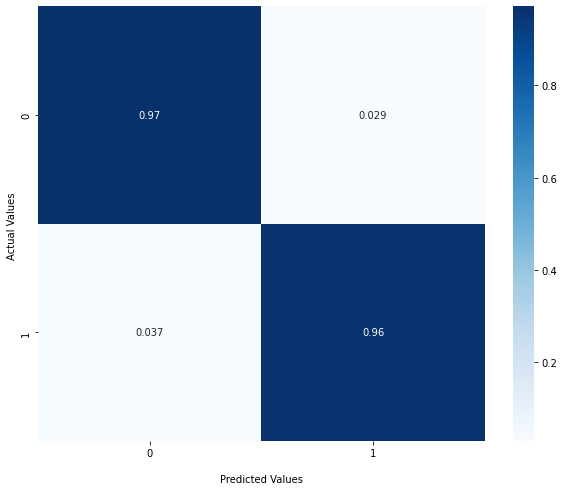

In [42]:
fig,ax = plt.subplots(figsize = (10,8) )

sns.heatmap(confusion_matrix(test_target,predictions , normalize='true'
                            ),annot=True,ax = ax,cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

In [22]:
cols_to_drop = ['trans_date_trans_time',
                'first',
                'last',
                'dob',
                'trans_num',
                'unix_time',
                'trans_date_trans_time_caldate',
                'dob_caldate'
                
               ]


pp_list = [
    
    #("cc_length",ValueLength(col=["cc_num"]))
    
    ("txn_date_decom",DateDecomp(col = ["trans_date_trans_time"]))
    
    ,("dob_decomp",DateDecomp(col = ["dob"]))
    
#     #,("WeekdayCat",WeekCategory(["trans_date_trans_time_weekday"]))
    
#     #,("purchase_cat",PurchaseType(["category"]))
    
#     #,("daily_amount",Aggregator(partition_col=["cc_num","state","zip","merchant","city","category","gender"],agg_col="amt",agg_value="sum"))
    
     ,("avg_txn_amount",Aggregator(partition_col=["cc_num","gender"],date_col=['trans_date_trans_time_caldate'],agg_col="amt",agg_value="sum"))
    
#     ,("std_amt_per_txn",AggAmtperTxn(partition_col=["category"],date_col=['trans_date_trans_time_year'],agg_type='std'))
    
    
#     #,("daily_volume",Aggregator(partition_col=["cc_num","state","zip","merchant","city","category","gender"],agg_value="count"))
    
     ,("amt_per_txn",AggAmtperTxn(partition_col=["cc_num"]))
    
#     # ,("avg_merchants_year",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_year"],agg_value="nunique" ) )
#     # ,("avg_merchants_month",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_month"],agg_value="nunique" ) )
#     # ,("avg_merchants_week",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_week"],agg_value="nunique" ) )
#     # ,("avg_merchants_weekday",Aggregator(partition_col=["cc_num","state","city","zip","dob_year"],agg_col="merchant",date_col=["trans_date_trans_time_weekday"],agg_value="nunique" ) )
    
    
     ,("fraud_freq",FraudFreq(col = ["trans_date_trans_time_hour"]))
    
    
#     ,("hash_value",FarmHash(col = ["category"]))
    
#     #,("hot_encoding",OneHotEncoder(variables=["category_purchase_type","state","trans_date_trans_time_weekday_category","gender"]))
    
    
#    ,("log_transform",LogTransformer(variables=['cc_num_mean_caldate_sum_amt', 'gender_mean_caldate_sum_amt', 'category_std_year_amt_per_txn', 'cc_num_mean_caldate_amt_per_txn','amt','dob_year']  ))
 
# # ,("drop_features",DropFeatures(features_to_drop=cols_to_drop))
# #  ,('drop_constant_features',DropConstantFeatures(tol=0.98))
# #  ,('drop_corr_features',DropCorrelatedFeatures(threshold=0.9))
# ,('normalizer', SklearnTransformerWrapper(transformer=MinMaxScaler()))
# ,("replace_nan",ReplaceNaN())
# ,("selector",SelectFeatures(['category', 'amt', 'trans_date_trans_time_hour', 'dob_year', 'cc_num_mean_caldate_sum_amt', 'gender_mean_caldate_sum_amt', 'category_std_year_amt_per_txn', 'cc_num_mean_caldate_amt_per_txn', 'trans_date_trans_time_hour_fraud_freq'])) 
 ]


In [23]:
pipe = Pipeline(pp_list)

In [26]:
tt = pipe.fit_transform(train,y_train_pred)
#ttest = pipe.fit_transform(test)

C:\Users\vince\AppData\Local\Temp\ipykernel_24856\80048419.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X[dates+"_week"] = pd.DatetimeIndex(X[dates]).week
C:\Users\vince\AppData\Local\Temp\ipykernel_24856\80048419.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X[dates+"_week"] = pd.DatetimeIndex(X[dates]).week


In [27]:
tt[:5]

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,trans_date_trans_time_year,trans_date_trans_time_month,trans_date_trans_time_week,trans_date_trans_time_weekday,trans_date_trans_time_hour,trans_date_trans_time_caldate,trans_date_trans_time_day,dob_year,dob_month,dob_week,dob_weekday,dob_hour,dob_caldate,dob_day,cc_num_mean_caldate_sum_amt,gender_mean_caldate_sum_amt,cc_num_mean_caldate_amt_per_txn,trans_date_trans_time_hour_fraud_freq
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,2019,1,1,1,0,2019-01-01,1,1988,3,10,2,0,1988-03-09,9,345.484288,92798.161695,85.442088,0.01494
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,2019,1,1,1,0,2019-01-01,1,1978,6,25,2,0,1978-06-21,21,307.846403,92798.161695,53.786257,0.01494
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,2019,1,1,1,0,2019-01-01,1,1962,1,3,4,0,1962-01-19,19,102.896366,77076.007579,67.743193,0.01494
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,2019,1,1,1,0,2019-01-01,1,1967,1,2,3,0,1967-01-12,12,118.412211,77076.007579,65.227457,0.01494
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,2019,1,1,1,0,2019-01-01,1,1986,3,13,4,0,1986-03-28,28,372.765456,77076.007579,94.427516,0.01494


In [39]:
tt["trans_date_trans_time"].iat[0]

Timestamp('2019-01-01 00:00:18')

In [19]:
import datetime


In [22]:
datetime.datetime.strftime(tt["trans_date_trans_time_caldate"].iat[0],format = "%Y-%m-%d")

'2019-01-01'

In [17]:
date_list = train["trans_date_trans_time"].iat[0].split( )[0].split("-")
time_list = train["trans_date_trans_time"].iat[0].split( )[1].split(":")
year,month,day = int(date_list[0]),int(date_list[1]),int(date_list[2])
hour = int(time_list[0])

In [26]:
int(train["dob"].iat[0].split("-")[0])

1988